In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_rows', None)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
train_df.head()
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
def plot_missing_data(dataset, title):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)  
    sns.heatmap(dataset.isnull(), cbar=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


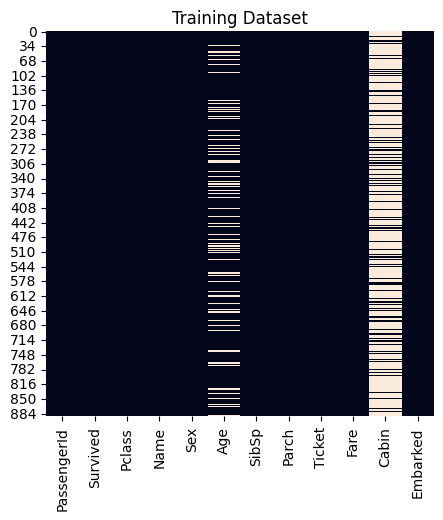

In [4]:
train_df.info()
plot_missing_data(train_df, "Training Dataset")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


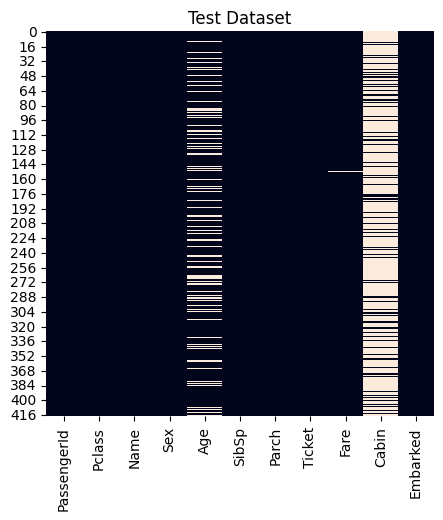

In [5]:
test_df.info()
plot_missing_data(test_df, "Test Dataset")


Observation:

From the blots above we can see that both training as well as test dataset contain features with missing values. However, the most sparse features are Age as well as Cabin.

As we do not know the how mich information the features yield, further investigation is needed.

In [6]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))


In [7]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

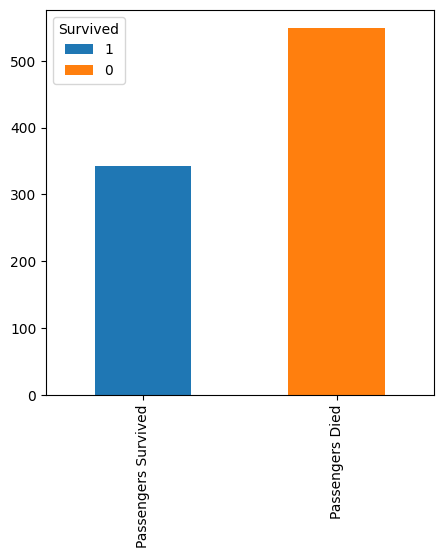

In [8]:
train_df['Survived'].value_counts(normalize=True)
bar_chart_stacked(train_df, "Survived")

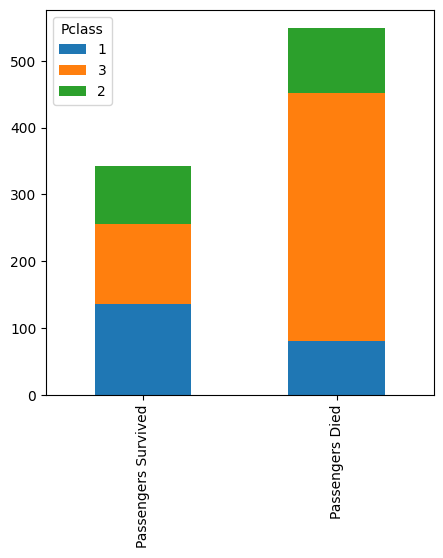

In [9]:
bar_chart_stacked(train_df, 'Pclass')

In [10]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [11]:
train_df.groupby(['Pclass']).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [12]:
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')

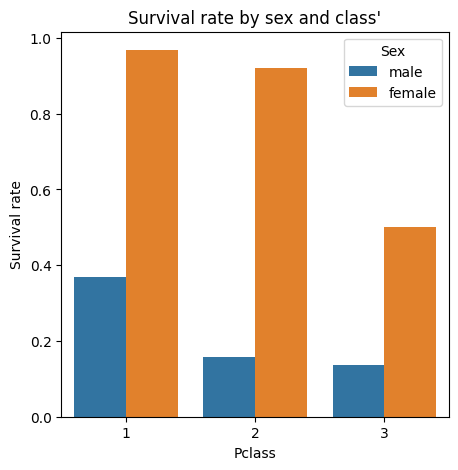

In [13]:
bar_chart_compare(train_df, "Pclass", "Sex")

In [14]:
pd.pivot_table(train_df, index = 'Survived', columns = ['Pclass', "Sex"], values = 'Ticket' ,aggfunc ='count')

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [15]:
train_df.groupby(['Pclass', "Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [16]:
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)

def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 1],
                shade= True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 0],
                shade=True, ax=ax, label="Died")

/tmp/ipykernel_20/2673402846.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)


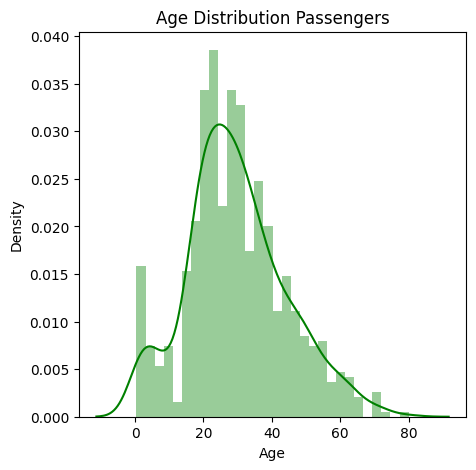

In [17]:
plot_distribution(train_df, "Age", "Age Distribution Passengers")

/tmp/ipykernel_20/2673402846.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 1],
/tmp/ipykernel_20/2673402846.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 0],


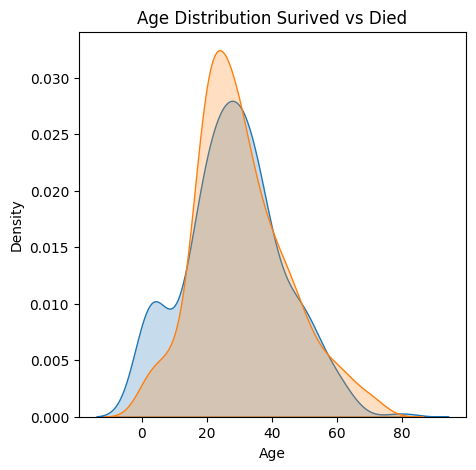

In [18]:
plot_kernel_density_estimate_survivors(train_df, "Age", "Age Distribution Surived vs Died")

In [19]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis.
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=train_df).set_title(title)

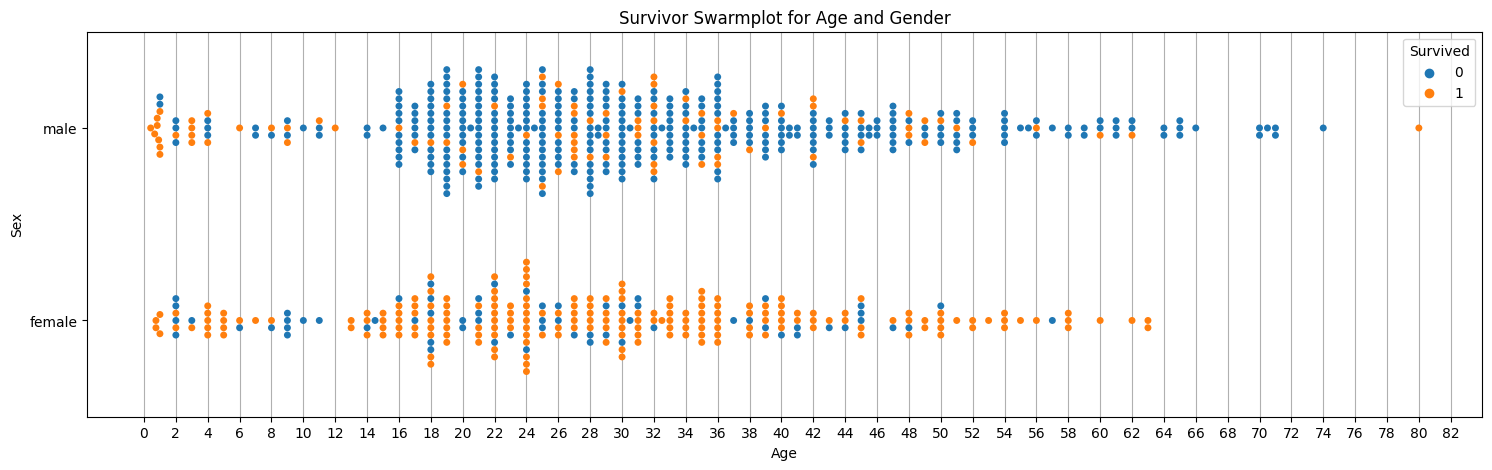

In [20]:
plot_swarm_survivors(train_df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 55.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 76.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


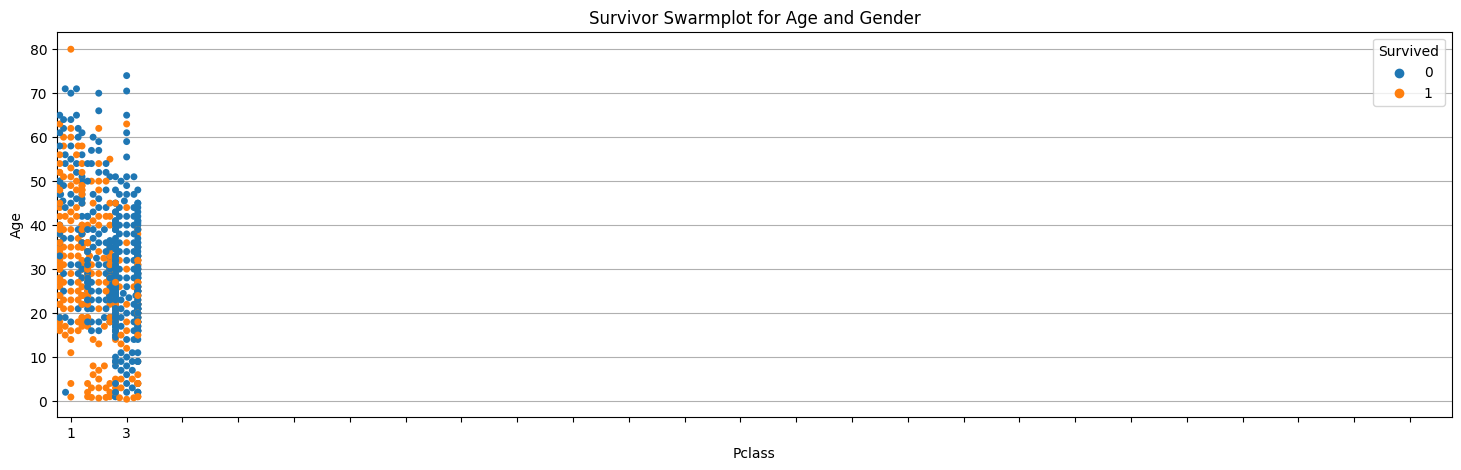

In [21]:
plot_swarm_survivors(train_df, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

In [22]:
train_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

/tmp/ipykernel_20/2673402846.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)


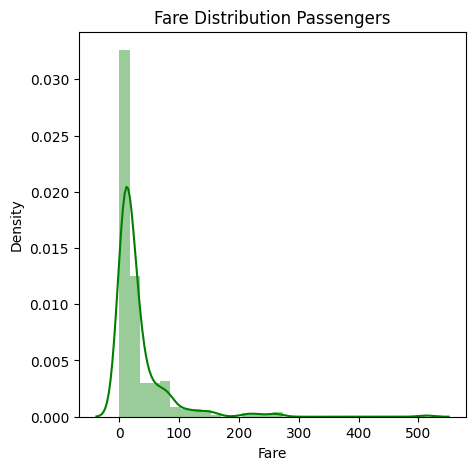

In [23]:
plot_distribution(train_df, "Fare", "Fare Distribution Passengers")

In [24]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')


/tmp/ipykernel_20/1317736120.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')


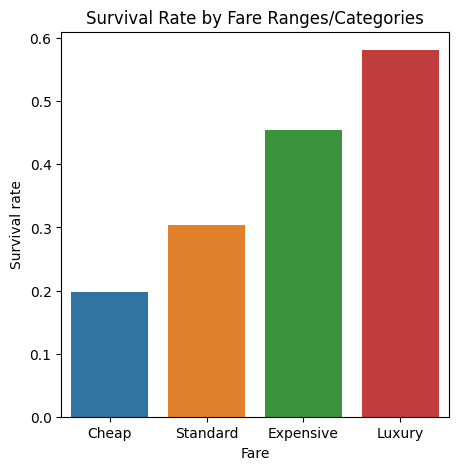

In [25]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']
plot_quartiles(train_df, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 91.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 83.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


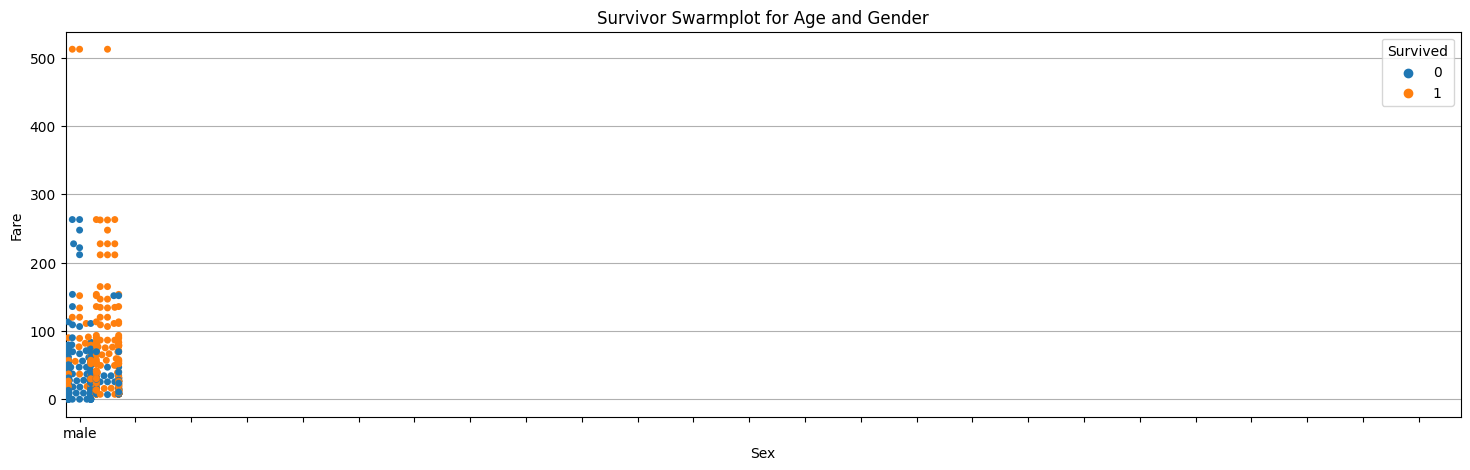

In [26]:
plot_swarm_survivors(train_df, "Fare", "Sex","Survivor Swarmplot for Age and Gender")

In [27]:
train_df.loc[train_df.Fare==0] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [28]:
len(train_df.loc[train_df.Fare==0])

15

In [29]:
# Replace Fare == 0 with nan
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN
test_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN

In [30]:
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)   


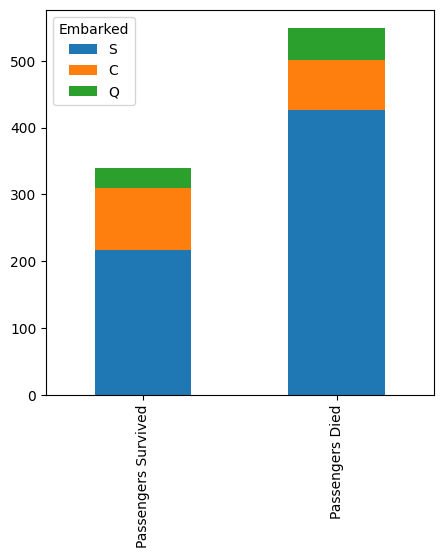

In [31]:
bar_chart_stacked(train_df, 'Embarked') 

In [32]:
train_df['Embarked'].value_counts().to_frame()

,count
Embarked,
S,644
C,168
Q,77


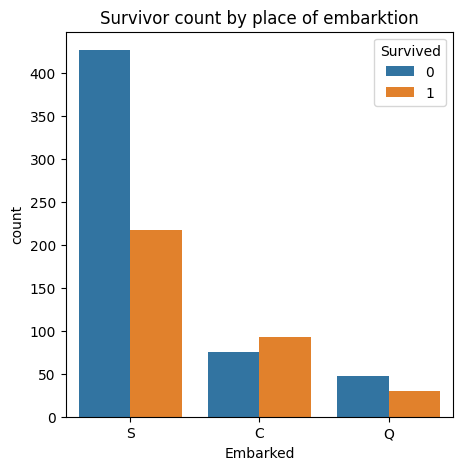

In [33]:
show_compare_countplot(train_df, "Embarked", "Survived", "Survivor count by place of embarktion")

In [34]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [35]:
train_df.groupby(['Embarked']).Survived.mean().to_frame()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


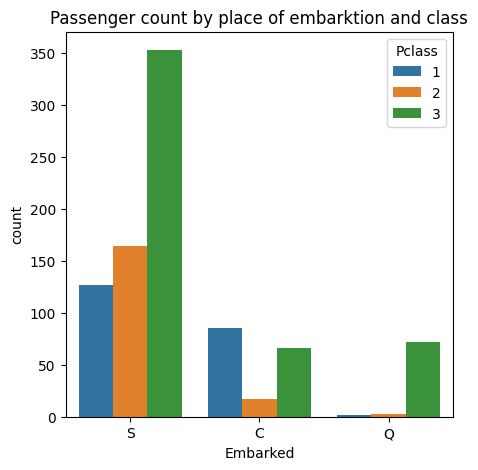

In [36]:
show_compare_countplot(train_df, "Embarked", "Pclass", "Passenger count by place of embarktion and class")


In [37]:
train_df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()


Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

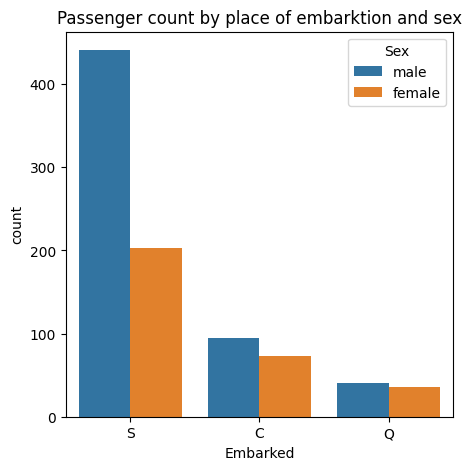

In [38]:
show_compare_countplot(train_df, "Embarked", "Sex", "Passenger count by place of embarktion and sex")


In [39]:
train_df['SibSp'].value_counts().to_frame()


,count
SibSp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


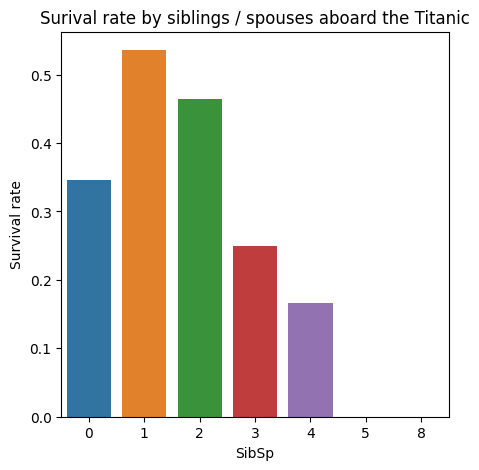

In [40]:
bar_chart_compare(train_df, "SibSp", title = "Surival rate by siblings / spouses aboard the Titanic")


In [41]:
train_df.groupby(['SibSp']).Survived.mean().to_frame()


,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


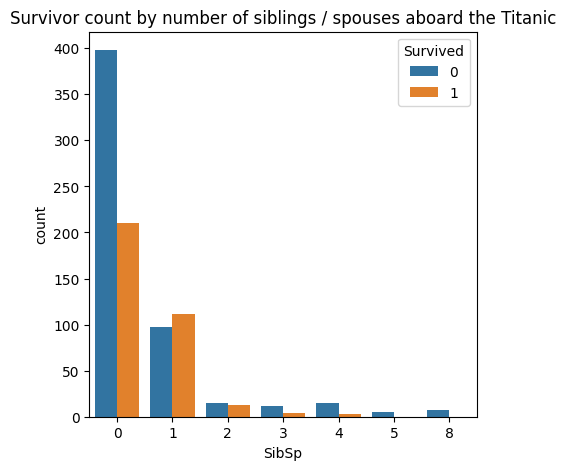

In [42]:
show_compare_countplot(train_df, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")


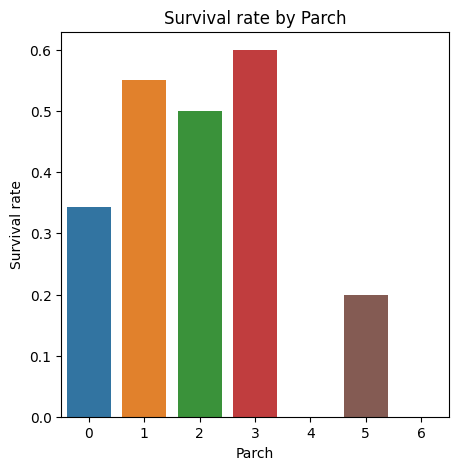

In [43]:
bar_chart_compare(train_df, "Parch", title = "Survival rate by Parch")


In [44]:
train_df.groupby(['Parch']).Survived.mean().to_frame()


,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


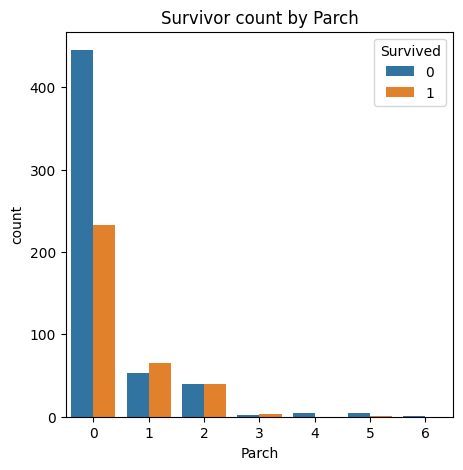

In [45]:
show_compare_countplot(train_df, "Parch", "Survived", "Survivor count by Parch")


In [46]:
pd.unique(train_df['Name'])


array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [47]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())


In [48]:
train_df['Title'].value_counts().to_frame()


,count
Title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2


In [49]:
train_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
test_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
train_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
test_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)


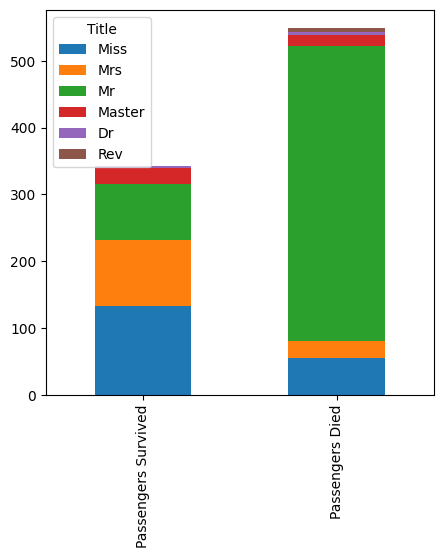

In [50]:
bar_chart_stacked(train_df, 'Title') 


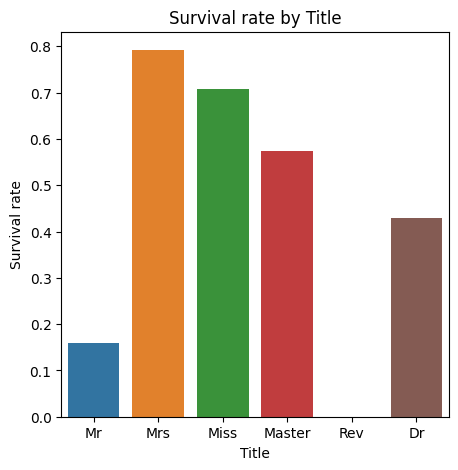

In [51]:
bar_chart_compare(train_df, "Title", title = "Survival rate by Title")


In [52]:
train_df[['Cabin', 'Ticket']]


,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
5,NaN,330877
6,E46,17463
7,NaN,349909
8,NaN,347742
9,NaN,237736


In [53]:
# Extract Leading Letter:
train_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x: x[:2])
test_df['Ticket_2letter'] = test_df.Ticket.apply(lambda x: x[:2])
# Extract Ticket Lenght:
train_df['Ticket_len'] = train_df.Ticket.apply(lambda x: len(x))
test_df['Ticket_len'] = test_df.Ticket.apply(lambda x: len(x))
# Extract Number of Cabins:
train_df['Cabin_num'] = train_df.Ticket.apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x.split()))
# Extract Leading Letter:
train_df['Cabin_1letter'] = train_df.Ticket.apply(lambda x: x[:1])
test_df['Cabin_1letter'] = test_df.Ticket.apply(lambda x: x[:1])


In [54]:
len(train_df['Cabin'].value_counts().to_frame())


147

In [55]:
len(train_df['Cabin_num'].value_counts().to_frame())


3

In [56]:
train_df['Cabin_num'].value_counts().to_frame()


,count
Cabin_num,
1,665
2,213
3,13


In [57]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,ST,16,2,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3


In [58]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1


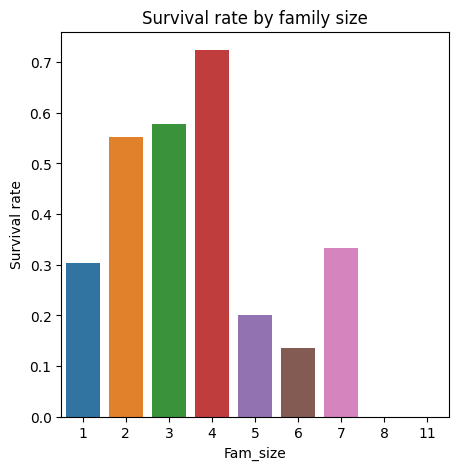

In [59]:
bar_chart_compare(train_df, "Fam_size", title = "Survival rate by family size")


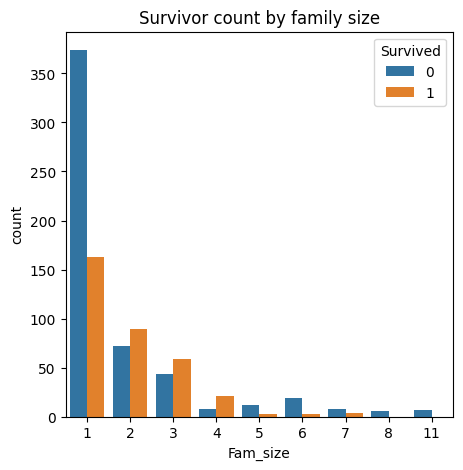

In [60]:
show_compare_countplot(train_df, "Fam_size", "Survived", "Survivor count by family size")


In [61]:
# Creation of four groups
train_df['Fam_type'] = pd.cut(train_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_df['Fam_type'] = pd.cut(test_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])


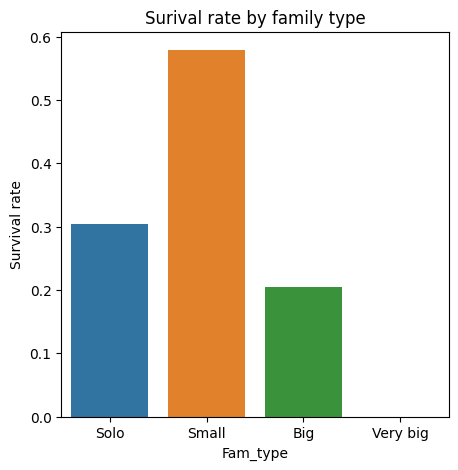

In [62]:
bar_chart_compare(train_df, "Fam_type", title = "Surival rate by family type")


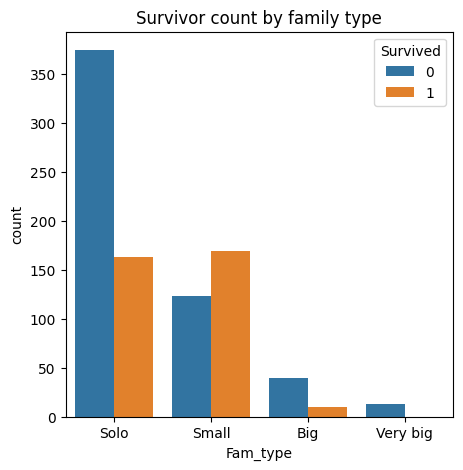

In [63]:
show_compare_countplot(train_df, "Fam_type", "Survived", "Survivor count by family type")


In [64]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']
X = train_df[features]
X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter
0,3,7.2500,Mr,S,Small,9,A/
1,1,71.2833,Mrs,C,Small,8,PC
2,3,7.9250,Miss,S,Solo,16,ST
3,1,53.1000,Mrs,S,Small,6,11
4,3,8.0500,Mr,S,Solo,6,37


In [65]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']

# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')

# Inputing missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Training
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))


Cross validation score: 0.826


In [66]:
X_test = test_df[features]
X_test.head()


,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter
0,3,7.8292,Mr,Q,Solo,6,33
1,3,7.0000,Mrs,S,Small,6,36
2,2,9.6875,Mr,Q,Solo,6,24
3,3,8.6625,Mr,S,Solo,6,31
4,3,12.2875,Mrs,S,Small,7,31


In [67]:
predictions = titanic_pipeline.predict(X_test)


In [68]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')


Your submission was successfully saved!
